## MODELING

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scipy.stats as stats
import seaborn as sns
import numpy as np

from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV


from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import MultinomialNB, GaussianNB
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier


from sklearn.metrics import confusion_matrix, plot_confusion_matrix, precision_score  
from sklearn.metrics import recall_score, accuracy_score, f1_score, log_loss
from sklearn.metrics import roc_curve, roc_auc_score, classification_report, plot_roc_curve
from sklearn.metrics import classification_report, auc, multilabel_confusion_matrix

from sklearn.pipeline import Pipeline

from sklearn.preprocessing import OneHotEncoder, StandardScaler, LabelEncoder 
from sklearn.preprocessing import MinMaxScaler, FunctionTransformer, OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.impute import MissingIndicator, SimpleImputer


from imblearn.over_sampling import SMOTE
from imblearn.pipeline import Pipeline as ImPipeline

from imblearn.over_sampling import SMOTE
from imblearn.under_sampling import RandomUnderSampler
from imblearn.pipeline import Pipeline as imbPipeline
from collections import Counter
from numpy import where




%matplotlib inline

In [2]:
water_pump = pd.read_csv('Data/cleaned_water_pump.csv')
water_pump.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group,unknown_construction_yr,age_at_inspection,water_per_person
0,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,gravity,...,pay annually,good,enough,spring,groundwater,communal standpipe,0,False,12.0,55.045872
1,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,gravity,...,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0,False,3.0,0.000000
2,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,gravity,...,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0,False,4.0,0.100000
3,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,submersible,...,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,2,False,27.0,0.000000
4,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,gravity,...,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0,True,NaN,NaN


In [3]:
water_pump['region_code'] = water_pump['region_code'].astype('str')

In [4]:
water_pump.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 59399 entries, 0 to 59398
Data columns (total 23 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   amount_tsh               59399 non-null  float64
 1   gps_height               59399 non-null  int64  
 2   basin                    59399 non-null  object 
 3   region                   59399 non-null  object 
 4   region_code              59399 non-null  object 
 5   lga                      59399 non-null  object 
 6   public_meeting           59399 non-null  object 
 7   scheme_management        59399 non-null  object 
 8   permit                   59399 non-null  object 
 9   extraction_type_group    59399 non-null  object 
 10  extraction_type_class    59399 non-null  object 
 11  management               59399 non-null  object 
 12  management_group         59399 non-null  object 
 13  payment                  59399 non-null  object 
 14  quality_group         

In [5]:
water_pump['status_group'].value_counts()

0    32259
2    22823
1     4317
Name: status_group, dtype: int64

In [6]:
#encoding target variables
le = LabelEncoder()
water_pump["status_group"] = le.fit_transform(water_pump["status_group"])
water_pump.head()

,amount_tsh,gps_height,basin,region,region_code,lga,public_meeting,scheme_management,permit,extraction_type_group,...,payment,quality_group,quantity,source,source_class,waterpoint_type,status_group,unknown_construction_yr,age_at_inspection,water_per_person
0,6000.0,1390,Lake Nyasa,Iringa,11,Ludewa,True,VWC,False,gravity,...,pay annually,good,enough,spring,groundwater,communal standpipe,0,False,12.0,55.045872
1,0.0,1399,Lake Victoria,Mara,20,Serengeti,Unknown,Other,True,gravity,...,never pay,good,insufficient,rainwater harvesting,surface,communal standpipe,0,False,3.0,0.000000
2,25.0,686,Pangani,Manyara,21,Simanjiro,True,VWC,True,gravity,...,pay per bucket,good,enough,dam,surface,communal standpipe multiple,0,False,4.0,0.100000
3,0.0,263,Ruvuma / Southern Coast,Mtwara,90,Nanyumbu,True,VWC,True,submersible,...,never pay,good,dry,machine dbh,groundwater,communal standpipe multiple,2,False,27.0,0.000000
4,0.0,0,Lake Victoria,Kagera,18,Karagwe,True,Unknown,True,gravity,...,never pay,good,seasonal,rainwater harvesting,surface,communal standpipe,0,True,NaN,NaN


## Setting up pipeline and functions

In [7]:
#function from lecture
class ModelWithCV():
    '''Structure to save the model and more easily see its crossvalidation'''
    
    def __init__(self, model, model_name, X, y, cv_now=True):
        self.model = model
        self.name = model_name
        self.X = X
        self.y = y
        # For CV results
        self.cv_results = None
        self.cv_mean = None
        self.cv_median = None
        self.cv_std = None
        #
        if cv_now:
            self.cross_validate()
        
    def cross_validate(self, X=None, y=None, kfolds=10):
        '''
        Perform cross-validation and return results.
        
        Args: 
          X:
            Optional; Training data to perform CV on. Otherwise use X from object
          y:
            Optional; Training data to perform CV on. Otherwise use y from object
          kfolds:
            Optional; Number of folds for CV (default is 10)  
        '''
        
        cv_X = X if X else self.X
        cv_y = y if y else self.y

        self.cv_results = cross_val_score(self.model, cv_X, cv_y, cv=kfolds)
        self.cv_mean = np.mean(self.cv_results)
        self.cv_median = np.median(self.cv_results)
        self.cv_std = np.std(self.cv_results)

        
    def print_cv_summary(self):
        cv_summary = (
        f'''CV Results for `{self.name}` model:
            {self.cv_mean:.5f} ± {self.cv_std:.5f} accuracy
        ''')
        print(cv_summary)

        
    def plot_cv(self, ax):
        '''
        Plot the cross-validation values using the array of results and given 
        Axis for plotting.
        '''
        ax.set_title(f'CV Results for `{self.name}` Model')
        # Thinner violinplot with higher bw
        sns.violinplot(y=self.cv_results, ax=ax, bw=.4)
        sns.swarmplot(
                y=self.cv_results,
                color='orange',
                size=10,
                alpha= 0.8,
                ax=ax
        )

        return ax

In [8]:
X = water_pump.drop('status_group', axis=1)
y = water_pump['status_group']
X_train, X_test, y_train, y_test = train_test_split(X, y, random_state=42)

In [9]:
numeric_cols = ["amount_tsh", "gps_height", "age_at_inspection", "water_per_person"]

cat_cols =["basin", "region", "region_code", "lga", "public_meeting", "scheme_management", "permit",
          "extraction_type_group", "extraction_type_class", "management", "management_group", "payment", "quality_group",
          "quantity", "source", "source_class", "waterpoint_type"]
bool_cols = ["unknown_construction_yr"]

In [10]:
subpipe_num = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("ss", StandardScaler())])
subpipe_cat = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [11]:
subpipe_num1 = Pipeline(steps=[("num_impute", SimpleImputer(strategy="mean")),("mm", MinMaxScaler())])
subpipe_cat1 = Pipeline(steps=[("ohe", OneHotEncoder(sparse=False, handle_unknown="ignore"))])
subpipe_ord1 = Pipeline(steps= [("ord_encode", OrdinalEncoder())])

In [12]:
#Column Transformers
CT = ColumnTransformer(transformers=[
                                    ("subpipe_num", subpipe_num, numeric_cols), 
                                     ("subpipe_cat", subpipe_cat, cat_cols),
                                    ("subpipe_ord", subpipe_ord, bool_cols)
                                    ], 
                       remainder="drop"
                      )

In [13]:
#Column Transformers
CT1 = ColumnTransformer(transformers=[
                                    ("subpipe_num1", subpipe_num1, numeric_cols), 
                                     ("subpipe_cat1", subpipe_cat1, cat_cols),
                                    ("subpipe_ord1", subpipe_ord1, bool_cols)
                                    ], 
                       remainder="drop"
                      )

## DUMMY MODEL

In [68]:
dummy_model_pipe = Pipeline(steps=[('ct', CT), ('dummy_model', 
                                                DummyClassifier(strategy="most_frequent",random_state=42))])

In [69]:
dummy_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [70]:
dummy_model_pipe.score(X_train, y_train)

0.542334455667789

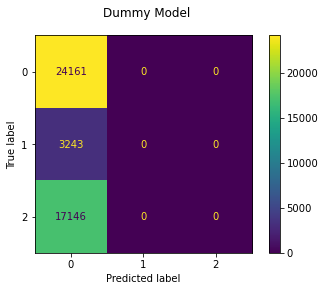

In [71]:
fig, ax = plt.subplots()

fig.suptitle("Dummy Model")

#Plot confusion matrix
plot_confusion_matrix(dummy_model_pipe, X_train, y_train, ax =ax);

In [72]:
dummy_y_pred = dummy_model_pipe.predict(X_test)
dummy_y_pred

array([0, 0, 0, ..., 0, 0, 0])

In [73]:
recall_score(y_test, y_pred, average='micro')

0.5482154882154883

In [74]:
print(classification_report(y_test, dummy_y_pred));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       0.00      0.00      0.00      1074
           2       0.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.18      0.33      0.24     14850
weighted avg       0.30      0.55      0.38     14850



/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/metrics/_classification.py:1221: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [75]:
multilabel_confusion_matrix(y_test, dummy_y_pred)

array([[[    0,  6752],
        [    0,  8098]],

       [[13776,     0],
        [ 1074,     0]],

       [[ 9172,     0],
        [ 5678,     0]]])

## Model -2 - Logistic

In [17]:
logreg_model_pipe = Pipeline(steps=[('ct', CT1), 
                                    ('logreg', LogisticRegression(random_state=42))])

In [18]:
logreg_model_pipe.fit(X_train, y_train)
logreg_model_pipe.score(X_train, y_train)

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:762: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


0.751358024691358

## Model 3 - Logistic

In [14]:
logreg_model_pipe = Pipeline(steps=[('ct', CT1), 
                                    ('logreg', LogisticRegression(random_state=42, max_iter=1000))])

In [15]:
logreg_model_pipe.fit(X_train, y_train)
logreg_model_pipe.score(X_train, y_train)

0.7489056993422972

In [16]:
log_y_pred = logreg_model_pipe.predict(X_test)
print(classification_report(y_test, log_y_pred));

              precision    recall  f1-score   support

           0       0.74      0.88      0.80      8131
           1       0.51      0.13      0.21      1046
           2       0.78      0.67      0.72      5673

    accuracy                           0.75     14850
   macro avg       0.68      0.56      0.58     14850
weighted avg       0.74      0.75      0.73     14850



## Model 4 - Optimal Logisic Regression Model

In [ ]:
optimal_log_model_pipe = Pipeline(steps=[('ct', CT), ('log', LogisticRegression(
    penalty='manhattan', solver=7, max_iter='distance', multi_class= '', C=''))])

In [ ]:
optimal_log_model_pipe.fit(X_train, y_train)

In [ ]:
optimal_log_model_pipe.score(X_train, y_train)

In [ ]:
log_opt_y_pred = optimal_log_model_pipe.predict(X_test)
print(classification_report(y_test, log_opt_y_pred ));

## Model 5 - First KNN

In [105]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT1), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=11, weights='distance'))])

In [106]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [ ]:
knneighbors_model_pipe.score(X_train, y_train)

In [ ]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, knn_y_pred));

## Model 6 - Optimal KNN

In [ ]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT1), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=17, weights='distance'))])

In [ ]:
knneighbors_model_pipe.fit(X_train, y_train)

In [ ]:
knneighbors_model_pipe.score(X_train, y_train)

In [ ]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)

In [ ]:
print(classification_report(y_test, knn_y_pred));

In [32]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT1), ('knn', KNeighborsClassifier(
    metric='manhattan', n_neighbors=27, weights='distance'))])

In [33]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
               

In [34]:
knneighbors_model_pipe.score(X_train, y_train)

0.9415263748597082

In [35]:
knn_y_pred = knneighbors_model_pipe.predict(X_test)

In [36]:
print(classification_report(y_test, knn_y_pred));

              precision    recall  f1-score   support

           0       0.78      0.87      0.82      8098
           1       0.48      0.33      0.39      1074
           2       0.81      0.73      0.77      5678

    accuracy                           0.78     14850
   macro avg       0.69      0.64      0.66     14850
weighted avg       0.77      0.78      0.77     14850



## Model 7 - Decision Tree Model

In [17]:
dct_model_pipe = Pipeline(steps=[('ct', CT1), ('Dct', DecisionTreeClassifier(
    class_weight='balanced', criterion='entropy', min_impurity_decrease=2))])

In [18]:
dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [19]:
dct_model_pipe.score(X_train, y_train)

0.5416058721856832

In [20]:
dct_y_pred = dct_model_pipe.predict(X_test)
print(classification_report(y_test, dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8131
           1       1.00      0.00      0.00      1046
           2       1.00      0.00      0.00      5673

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.39     14850



## Model 8 - Optimal Decision Tree Model

In [41]:
optimal_dct_model_pipe = Pipeline(steps=[('ct', CT1), ('Dct', DecisionTreeClassifier(
    class_weight=None, criterion='gini', min_impurity_decrease=0.15))])

In [42]:
optimal_dct_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('ss',
                                                                   StandardScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
               

In [43]:
optimal_dct_model_pipe.score(X_train, y_train)

0.542334455667789

In [44]:
opt_dct_y_pred = optimal_dct_model_pipe.predict(X_test)
print(classification_report(y_test, opt_dct_y_pred, zero_division=1 ));

              precision    recall  f1-score   support

           0       0.55      1.00      0.71      8098
           1       1.00      0.00      0.00      1074
           2       1.00      0.00      0.00      5678

    accuracy                           0.55     14850
   macro avg       0.85      0.33      0.24     14850
weighted avg       0.75      0.55      0.38     14850



## Model 9 - Random Forest Model

In [21]:
rfc_model_pipe = Pipeline(steps=[('ct', CT1), ('rfc', RandomForestClassifier(random_state=42))])

In [22]:
rfc_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [23]:
rfc_model_pipe.score(X_train, y_train)

0.9423556084311657

In [24]:
rfc_y_preds = rfc_model_pipe.predict(X_test)

print(classification_report(y_test, rfc_y_preds))

              precision    recall  f1-score   support

           0       0.80      0.86      0.83      8131
           1       0.44      0.32      0.37      1046
           2       0.80      0.76      0.78      5673

    accuracy                           0.78     14850
   macro avg       0.68      0.65      0.66     14850
weighted avg       0.78      0.78      0.78     14850



## Model 10 - Optimal Random Forest  Model

In [25]:
optimal_rfc_model_pipe = Pipeline(steps=[('ct', CT1), ('rfc', RandomForestClassifier(
      criterion='gini', min_samples_leaf=5, n_estimators=100))])

In [26]:
optimal_rfc_model_pipe.fit(X_train, y_train)


Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [27]:
optimal_rfc_model_pipe.score(X_train, y_train)

0.8047543154728501

In [28]:
opt_rfc_y_pred = optimal_rfc_model_pipe.predict(X_test)
print(classification_report(y_test, opt_rfc_y_pred ));

              precision    recall  f1-score   support

           0       0.76      0.92      0.83      8131
           1       0.66      0.15      0.24      1046
           2       0.83      0.71      0.76      5673

    accuracy                           0.78     14850
   macro avg       0.75      0.59      0.61     14850
weighted avg       0.78      0.78      0.76     14850



In [34]:
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat1"]

Pipeline(steps=[('ohe', OneHotEncoder(handle_unknown='ignore', sparse=False))])

In [35]:
optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat1"].named_steps["ohe"]

OneHotEncoder(handle_unknown='ignore', sparse=False)

In [36]:
cat_features_list = list(optimal_rfc_model_pipe.named_steps["ct"].named_transformers_["subpipe_cat1"].named_steps["ohe"].get_feature_names())


In [ ]:
X_train.head()

In [37]:

features_names = ["amount_tsh", "gps_height"] + cat_features_list + ["water_per_person", "unknown_construction_yr", "age_at_inspection"]

In [38]:
rfc_importances = optimal_rfc_model_pipe.named_steps["rfc"].feature_importances_

In [39]:
optimal_rfc_model_feature_importance_dict = dict(zip(features_names, rfc_importances)) 

In [40]:
sort_feature_importance = sorted(optimal_rfc_model_feature_importance_dict.items(), key=lambda x: x[1], reverse=True)

for i in sort_feature_importance:
    print(i[0], i[1])

x13_insufficient 0.13552540489287337
x0_Internal 0.055702551020325494
unknown_construction_yr 0.04945861142147675
x13_seasonal 0.045091641104655945
x8_submersible 0.03666863627487208
gps_height 0.0359275047284297
x7_other motorpump 0.03045178910994655
amount_tsh 0.027341243561752788
x0_Lake Nyasa 0.022837812276061447
x11_pay annually 0.01848414732982985
x13_unknown 0.018431473291485617
x16_dam 0.016592283134399696
x8_other 0.013759773331326504
x16_other 0.013430522024009836
x16_hand pump 0.01268878815539523
x13_enough 0.011617032835535085
x8_motorpump 0.01036328795290182
x7_india mark iii 0.009198500665124303
x15_groundwater 0.0091228740393814
x11_unknown 0.008954518752282228
x7_other handpump 0.008869286402514383
x9_water board 0.008150259332711178
x14_dam 0.0072842584651151565
x5_WUG 0.007244437049276196
x1_Kigoma 0.007004637760851961
x7_afridev 0.00694266933942102
x6_Unknown 0.00655240963364829
x16_cattle trough 0.006505064864390937
x15_unknown 0.006465696317285533
x12_fluoride 0.00

## Using Smote


description

In [41]:
# Check the class distribution of the target
counter = Counter(y_train)
print(counter)

Counter({0: 24128, 2: 17150, 1: 3271})


In [42]:
# Create the oversampler and undersampler objects
over = SMOTE(sampling_strategy="minority", random_state=42)
under = RandomUnderSampler(sampling_strategy="not minority", random_state=42)

## Optimal Random Forest with oversamping Minority and undersampling Majority Classes

In [43]:
rfc_over_under_smote_model_pipe = imbPipeline(steps=[('ct', CT1), ("over", over), ('rfc', RandomForestClassifier
                   (criterion= "gini", min_samples_split=6, n_estimators=150, random_state=42))])

In [44]:
rfc_over_under_smote_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [45]:
rfc_over_under_smote_model_pipe.score(X_train, y_train)

0.8838357763361692

In [46]:
rfc_over_under_smote_y_pred = rfc_over_under_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_under_smote_y_pred ));

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      8131
           1       0.33      0.51      0.40      1046
           2       0.84      0.74      0.78      5673

    accuracy                           0.77     14850
   macro avg       0.66      0.69      0.67     14850
weighted avg       0.79      0.77      0.77     14850



## Optimal Random Forest with oversamping Minority

In [47]:
rfc_over_smote_model_pipe = imbPipeline(steps=[('ct', CT1), ("over", over), ('rfc', 
                                     RandomForestClassifier(criterion= "gini", min_samples_split=6, 
                                                            n_estimators=150, random_state=42))])

In [48]:
rfc_over_smote_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [49]:
rfc_over_smote_model_pipe.score(X_train, y_train)

0.8838357763361692

In [50]:
rfc_over_smote_y_pred = rfc_over_smote_model_pipe.predict(X_test)
print(classification_report(y_test, rfc_over_smote_y_pred ));

              precision    recall  f1-score   support

           0       0.81      0.82      0.82      8131
           1       0.33      0.51      0.40      1046
           2       0.84      0.74      0.78      5673

    accuracy                           0.77     14850
   macro avg       0.66      0.69      0.67     14850
weighted avg       0.79      0.77      0.77     14850



In [51]:
counter = Counter(y_train)
print(counter)

Counter({0: 24128, 2: 17150, 1: 3271})


In [52]:
strategy = {0:24128, 2:17150., 1:6542}
oversample = SMOTE(sampling_strategy=strategy)


In [53]:
over = SMOTE(sampling_strategy="strategy", random_state=42)

In [54]:
imbal_knn_pipe = imbPipeline(steps=[('ct', CT1), ("over", over), 
                ('knn', KNeighborsClassifier(metric='manhattan', 
                n_neighbors=17, weights='distance'))])


In [55]:
imbal_knn_pipe.fit(X_train, y_train)

ValueError: When 'sampling_strategy' is a string, it needs to be one of {'minority': <function _sampling_strategy_minority at 0x7fd73cfb1af0>, 'majority': <function _sampling_strategy_majority at 0x7fd73cfb1940>, 'not minority': <function _sampling_strategy_not_minority at 0x7fd73cfb1a60>, 'not majority': <function _sampling_strategy_not_majority at 0x7fd73cfb19d0>, 'all': <function _sampling_strategy_all at 0x7fd73cfb18b0>, 'auto': <function _sampling_strategy_auto at 0x7fd73cfb1b80>}. Got 'strategy' instead.

In [ ]:
imbal_knn_pipe.score(X_train, y_train)

In [ ]:
imbal_knn_y_pred = imbal_knn_pipe. predict(X_test)
print(classification_report(y_test, imbal_knn_y_pred));

In [ ]:
imbal_knn_pipe2 = imbPipeline(steps=[('ct', CT1), ("over", over), 
                ('knn', KNeighborsClassifier(metric='manhattan', 
                n_neighbors=11, weights='distance'))])

In [ ]:
imbal_knn_pipe2.fit(X_train, y_train)

In [ ]:
imbal_knn_pipe2.score(X_train, y_train)

In [ ]:
imbal_knn_y_pred = imbal_knn_pipe2. predict(X_test)
print(classification_report(y_test, imbal_knn_y_pred));

In [56]:
dt_model_pipe = Pipeline(steps=[('ct', CT1), ('dt', DecisionTreeClassifier(random_state=42, min_impurity_decrease= 1))])

In [57]:
dt_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [58]:
dt_model_pipe.score(X_train, y_train)

0.5416058721856832

In [59]:
pipe_grid_dt = {
    'dt__criterion': ['gini', 'entropy'], 
    'dt__class_weight': ['None', 'balanced'],
    'dt__min_impurity_decrease': [1, 2, 3, 4, 5]

}


gs_pipe_dt = GridSearchCV(estimator=dt_model_pipe, param_grid=pipe_grid_dt)

In [60]:
gs_pipe_dt.fit(X_train, y_train)

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 199, in fit
    expanded_class_weight = compute_sample_weight(
  File "/

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num1',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                                        ('subpipe

In [61]:
print(gs_pipe_dt.best_params_)
print(gs_pipe_dt.best_score_)
print(gs_pipe_dt.best_estimator_.score(X_train, y_train))

{'dt__class_weight': 'balanced', 'dt__criterion': 'gini', 'dt__min_impurity_decrease': 1}
0.41665709110914345
0.5416058721856832


In [ ]:
knneighbors_model_pipe = Pipeline(steps=[('ct', CT1), ('knn', KNeighborsClassifier())])

In [63]:
knneighbors_model_pipe.fit(X_train, y_train)

Pipeline(steps=[('ct',
                 ColumnTransformer(transformers=[('subpipe_num1',
                                                  Pipeline(steps=[('num_impute',
                                                                   SimpleImputer()),
                                                                  ('mm',
                                                                   MinMaxScaler())]),
                                                  ['amount_tsh', 'gps_height',
                                                   'age_at_inspection',
                                                   'water_per_person']),
                                                 ('subpipe_cat1',
                                                  Pipeline(steps=[('ohe',
                                                                   OneHotEncoder(handle_unknown='ignore',
                                                                                 sparse=False))]),
                 

In [64]:
knneighbors_model_pipe.score(X_train, y_train)

0.8248894475745808

In [65]:
pipe_grid = {
    'knn__n_neighbors': [3, 5, 7, 9, 11, 13, 15, 17], 
    'knn__metric': ['minkowski', 'manhattan', 'euclidean'],
    'knn__weights': ['uniform', 'distance']

}


gs_pipe = GridSearchCV(estimator=knneighbors_model_pipe, param_grid=pipe_grid)

In [66]:
gs_pipe.fit(X_train, y_train)

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num1',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('mm',
                                                                                          MinMaxScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                                        ('subpipe

In [67]:
print(gs_pipe.best_params_)
print(gs_pipe.best_score_)
print(gs_pipe.best_estimator_.score(X_train, y_train))

{'knn__metric': 'manhattan', 'knn__n_neighbors': 17, 'knn__weights': 'distance'}
0.7726774057533214
0.9419740061505308


## IGNORE WILL MOVE

In [49]:
dt_model_pipe = Pipeline(steps=[('ct', CT), ('dt', DecisionTreeClassifier(random_state=42, min_impurity_decrease= 0.3))])

In [50]:
pipe_grid_dt = {
    'dt__criterion': ['gini', 'entropy'], 
    'dt__class_weight': [None, 'balanced'],
    'dt__min_impurity_decrease': [0.15, 0.2, 0.3]

}


gs_pipe_dt = GridSearchCV(estimator=dt_model_pipe, param_grid=pipe_grid_dt)

In [51]:
gs_pipe_dt.fit(X_train, y_train)

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py:548: FitFailedWarning: Estimator fit failed. The score on this train-test partition for these parameters will be set to nan. Details: 
Traceback (most recent call last):
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/model_selection/_validation.py", line 531, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/pipeline.py", line 335, in fit
    self._final_estimator.fit(Xt, y, **fit_params_last_step)
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 890, in fit
    super().fit(
  File "/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/tree/_classes.py", line 333, in fit
    criterion = CRITERIA_CLF[self.criterion](self.n_outputs_

GridSearchCV(estimator=Pipeline(steps=[('ct',
                                        ColumnTransformer(transformers=[('subpipe_num',
                                                                         Pipeline(steps=[('num_impute',
                                                                                          SimpleImputer()),
                                                                                         ('ss',
                                                                                          StandardScaler())]),
                                                                         ['amount_tsh',
                                                                          'gps_height',
                                                                          'age_at_inspection',
                                                                          'water_per_person']),
                                                                        ('subpip

In [102]:
print(gs_pipe_dt.best_params_)
print(gs_pipe_dt.best_score_)
print(gs_pipe_dt.best_estimator_.score(X_train, y_train))

{'dt__class_weight': None, 'dt__criterion': 'gini', 'dt__min_impurity_decrease': 0.15}
0.5416058717656353


/Users/mysterious/opt/anaconda3/envs/learn-env/lib/python3.8/site-packages/sklearn/compose/_column_transformer.py:437: FutureWarning: Given feature/column names or counts do not match the ones for the data given during fit. This will fail from v0.24.
  warnings.warn("Given feature/column names or counts do not match "


0.542334455667789
